In [114]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import math
import socket
import time

### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']


### Variables for UDP Send
# Set IP address as local host, 12000 is destination port
serverAddressPort = ("127.0.0.1", 12000)
bufferSize = 1024
UDPClientSocket = socket.socket(family=socket.AF_INET, type=socket.SOCK_DGRAM)
message = ""

# Mapping Function
def mapping(x,input_min,input_max,output_min,output_max):
    val = (x-input_min)*(output_max-output_min)/(input_max-input_min)+output_min
    if val < output_min:
        val = output_min
    elif val > output_max:
        val = output_max
    return val

### Draw EDGES
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,10]
]

# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 4
    lamdaVal = 0.885

    minBPD = 10.0
    maxBPD = 0.0
    
    saveNum = 0
    saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture('../../data/sampleVideo.mp4')
    while cap.isOpened():
        ret, frame = cap.read()

        ### Variables for each frame
        BPD = []
        
        # Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        # Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
        keypoints_only = np.delete(keypoints_with_scores,2,2)
        keypoints_only_body = np.delete(keypoints_only, [0,1,2,3,4], 1)

        # Calculate each vector for each person
        vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempVector = person[i[1]] - person[i[0]]
                tempPerson.append(tempVector)
                # print(person[i[1]] - person[i[0]])    # vector(second - first)
                # print("====")
            vectors_only_body.append(tempPerson)

        vectors_only_body = np.array(vectors_only_body)
        vectors_only_body.reshape(4,12,2)
        # print(vectors_only_body)
        # print("============")

        ### Calculate BPD(Body-part-level Pose Distance)
        for person in vectors_only_body:
            pass

        for i in range(12):
            tempBodyPart = []
            tempD = []
            
            # Calculate vector
            for person in vectors_only_body:
                tempBodyPart.append(person[i])
                # print(person[i])
                # print("====")
            tempBodyPart = np.array(tempBodyPart)
            tempAverageVector = tempBodyPart.mean(axis = 0)
            
            # Calculate d
            for vi in tempBodyPart:
                tempDVal = np.linalg.norm(vi - tempAverageVector)
                tempD = np.array(tempD)
                tempD = np.append(tempD, tempDVal)
            
            
            BPD = np.array(BPD)
            BPD = np.append(BPD, math.pow(tempD.mean(), lamdaVal))
        
        ### Check each Value....
        print(BPD)
        sumBPD = np.sum(BPD)
        print("sumBPD: ", sumBPD)
        mapBPD = int(mapping(sumBPD, 0.2, 0.5, 0.0, 255.0))
        print("mapBPD: ", mapBPD)

        if (minBPD > sumBPD):
            minBPD = sumBPD
        if (maxBPD < sumBPD):
            maxBPD = sumBPD
        print("minBPD: ", minBPD)   # BPD Maximum Value
        print("maxBPD: ", maxBPD)   # BPD Minimum Value
        print("===============")

        # Sending mapBPD to Processing....
        UDPClientSocket.sendto(str.encode(str(mapBPD)), serverAddressPort)

        # Drawing Colored Rectangle with mapBPD
        start_point = (0, 0)
        end_point = (30, 30)
        color = (0, 255-mapBPD, mapBPD)
        thickness = -1
        frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
        frame = cv2.putText(frame, str(sumBPD), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
        frame = cv2.putText(frame, str(BPD[:6]), (30,60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
        frame = cv2.putText(frame, str(BPD[6:]), (30,90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)


        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
        # loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....

        time.sleep(0.1)
        
        cv2.imshow('Movenet Multipose', frame)
        
        if cv2.waitKey(1) & 0xFF==ord('z'):
            saveBPD.append(BPD)
            cv2.imwrite('./' + str(saveNum) +'.jpg', frame)
            saveNum += 1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            rawData = np.array(saveBPD)
            df = pd.DataFrame(rawData)
            df.to_csv('sampleData.csv', index=False)
            break
    
    cap.release()
    cv2.destroyAllWindows()

[0.01123549 0.01414538 0.01878015 0.01721409 0.0168582  0.0279561
 0.02667851 0.00895161 0.01741572 0.0183544  0.02210598 0.0225796 ]
sumBPD:  0.222275231922164
mapBPD:  18
minBPD:  0.222275231922164
maxBPD:  0.222275231922164
[0.01121236 0.01401606 0.01871378 0.01961778 0.01667834 0.02788562
 0.02652763 0.00885705 0.01719671 0.01824185 0.02220337 0.02266209]
sumBPD:  0.22381263630198991
mapBPD:  20
minBPD:  0.222275231922164
maxBPD:  0.22381263630198991
[0.01121949 0.01434104 0.01867542 0.01728163 0.01687625 0.02788446
 0.02682702 0.00877558 0.01701904 0.01811718 0.02222464 0.02266474]
sumBPD:  0.22190650532791342
mapBPD:  18
minBPD:  0.22190650532791342
maxBPD:  0.22381263630198991
[0.01125406 0.01396337 0.01842851 0.0168926  0.01631579 0.02785047
 0.02683713 0.00877561 0.01722181 0.01813918 0.02190044 0.02253244]
sumBPD:  0.22011140762322168
mapBPD:  17
minBPD:  0.22011140762322168
maxBPD:  0.22381263630198991
[0.01145215 0.01380314 0.01873975 0.01909059 0.01680911 0.02813496
 0.027

[0.01144165 0.03168336 0.03806299 0.02430959 0.03347925 0.02303809
 0.02219929 0.00780768 0.03804935 0.01876908 0.04340617 0.05345224]
sumBPD:  0.3456987470688597
mapBPD:  123
minBPD:  0.21752878361309352
maxBPD:  0.3456987470688597
[0.01167851 0.02685103 0.03145893 0.02172285 0.02896684 0.02230989
 0.02295538 0.00849149 0.03459366 0.01917939 0.05731743 0.06464389]
sumBPD:  0.35016926938223875
mapBPD:  127
minBPD:  0.21752878361309352
maxBPD:  0.35016926938223875
[0.01441321 0.02492433 0.02895451 0.0243107  0.02138241 0.02357723
 0.02586525 0.01144177 0.03913276 0.01854492 0.03314473 0.03531549]
sumBPD:  0.30100730570606615
mapBPD:  85
minBPD:  0.21752878361309352
maxBPD:  0.35016926938223875
[0.01189902 0.02134932 0.02757323 0.02271663 0.02432962 0.01997227
 0.02287309 0.00986525 0.03730425 0.01870377 0.06268914 0.06674802]
sumBPD:  0.3460236037175377
mapBPD:  124
minBPD:  0.21752878361309352
maxBPD:  0.35016926938223875
[0.00863567 0.01732878 0.02654647 0.02169048 0.01562417 0.020538

In [1]:
import numpy as np
import pandas as pd

tempBPDData = pd.read_csv('./sampleBPDData.csv')
allBPD = tempBPDData.to_numpy()

In [3]:
tempBPDData.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
45,0.017660,0.030396,0.022670,0.022384,0.020548,0.033468,0.032331,0.007520,0.028279,0.021665,0.025635,0.040586
46,0.025753,0.030560,0.022915,0.029751,0.035864,0.034674,0.038768,0.016019,0.026238,0.049710,0.024482,0.041834
47,0.022923,0.058617,0.051026,0.033213,0.090172,0.024801,0.036791,0.017895,0.024113,0.034653,0.021502,0.039619
48,0.012290,0.033586,0.021406,0.037201,0.017840,0.025595,0.026730,0.007795,0.032553,0.032850,0.025127,0.049436
49,0.011367,0.019837,0.021530,0.023679,0.016957,0.027691,0.021669,0.009543,0.030570,0.028220,0.020989,0.033005


In [2]:
tempHumanData = pd.read_csv('./humanRatingData.csv')
humanRating = tempHumanData.to_numpy()

In [5]:
tempHumanData.tail()

,0
45,0.6
46,0.1
47,0.0
48,0.4
49,0.8


In [3]:
tempSimpleAddtion = pd.read_csv('./simpleAdditionData.csv')
simpleAddition = tempSimpleAddtion.to_numpy()

In [7]:
tempSimpleAddtion.tail()

,0
45,0.303142
46,0.376569
47,0.455325
48,0.322410
49,0.265057


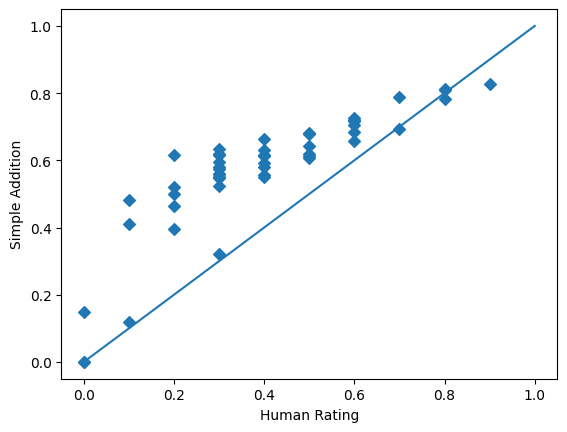

In [23]:
### Drawing Plot for Simple Addition
import matplotlib.pyplot as plt

### Simple Addition의 정규화
# Mapping Function
def mapping(x,input_min,input_max,output_min,output_max):
    val = (x-input_min)*(output_max-output_min)/(input_max-input_min)+output_min
    if val < output_min:
        val = output_min
    elif val > output_max:
        val = output_max
    return val
# 정규화
simpleAdditionNorm = []
for a in simpleAddition:
    tempVal = 1.0-mapping(a, 0.2, 0.5, 0.0, 1.0)
    simpleAdditionNorm.append(tempVal)

### Human-rating & simpleAddition의 산점도 그리기
plt.scatter(humanRating, simpleAdditionNorm, marker = 'D')

### 사선 긋기
x = np.arange(0,2)
y=x
plt.plot(x,y,'-')

### 산점도 라벨링
plt.xlabel('Human Rating')
plt.ylabel('Simple Addition')
plt.show()

In [51]:
### Simple Addtion Pearson R

from scipy.stats import pearsonr

tempHumanRating = np.squeeze(np.asarray(humanRating))
tempSimpleAdditionNorm = np.squeeze(np.asarray(simpleAdditionNorm))

pearsonr(tempHumanRating,tempSimpleAdditionNorm )

C:\Users\LeeSooHwan\AppData\Local\Temp\ipykernel_33496\1053800381.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tempSimpleAdditionNorm = np.squeeze(np.asarray(simpleAdditionNorm))


PearsonRResult(statistic=array([0.84216407]), pvalue=1.7988199762175145e-14)

# Data Preprocessing

In [38]:
### 훈련세트와 테스트 세트로 나누기 => 논문 방법
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(allBPD, humanRating)

In [28]:
### 훈련세트와 테스트 세트로 나누기 => simple addition
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(simpleAddition, humanRating)

# Linear SVR

In [35]:
### SVR
from sklearn.svm import LinearSVR

svm_reg = LinearSVR() # Tuning epsilon val!!
svm_reg.fit(train_input, train_target)

C:\Users\LeeSooHwan\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR()

In [30]:
print(svm_reg.score(train_input, train_target))    # 훈련세트 r^2
print(svm_reg.score(test_input, test_target))    # 테스트세트 r^2

0.3673491864149516
0.33361704694645267


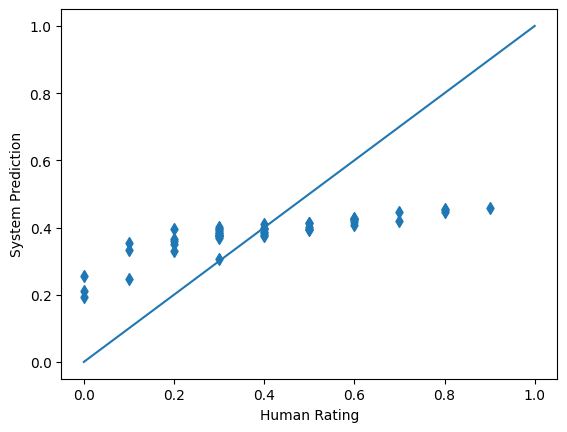

In [31]:
### Drawing Plot for SVR
import matplotlib.pyplot as plt

### Human-rating & SVR prediction의 산점도 그리기
# plt.scatter(humanRating, svm_reg.predict(allBPD), marker = 'd')
plt.scatter(humanRating, svm_reg.predict(simpleAddition), marker = 'd')

plt.plot(x,y,'-')

### 산점도 라벨링
plt.xlabel('Human Rating')
plt.ylabel('System Prediction')
plt.show()

In [48]:
### Simple Addtion Pearson R

from scipy.stats import pearsonr

tempHumanRating = np.squeeze(np.asarray(humanRating))
tempPrediction = np.squeeze(np.asarray(svm_reg.predict(simpleAddition).reshape(-1,1)))

pearsonr(tempHumanRating,tempPrediction )

PearsonRResult(statistic=0.8358046844215196, pvalue=4.303015036215309e-14)

In [44]:
svm_reg.predict(simpleAddition)

array([0.40032879, 0.36027422, 0.37534208, 0.39558935, 0.45400027,
       0.37833257, 0.38488392, 0.41387749, 0.41559277, 0.4       ,
       0.30728472, 0.39215543, 0.37492612, 0.44723804, 0.38868219,
       0.42841848, 0.39574295, 0.32928746, 0.42537316, 0.3954447 ,
       0.41442651, 0.24650588, 0.40296994, 0.34965944, 0.37571613,
       0.4095101 , 0.39606136, 0.39491942, 0.38423751, 0.37557408,
       0.36677431, 0.41819605, 0.42604307, 0.42233823, 0.39454895,
       0.45315973, 0.37741337, 0.37830713, 0.19197345, 0.20988199,
       0.35503079, 0.45819294, 0.39451516, 0.3825803 , 0.36751955,
       0.407247  , 0.33390532, 0.25523992, 0.38800175, 0.44528841])

# Linear Regression

In [80]:
### Linear Regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_input, train_target)

LinearRegression()

In [81]:
print(lr.score(train_input, train_target))    # 훈련세트 r^2
print(lr.score(test_input, test_target))    # 테스트세트 r^2

0.7020788534080993
0.6877087857091335


In [117]:
lr.predict([[0.323]])

array([[0.41934348]])

In [111]:
# Linear Regression 모델의 저장
import joblib

joblib.dump(lr, '../../model/lr_model.pkl')

['../../model/lr_model.pkl']

In [54]:
import joblib

lr = joblib.load('../../model/lr_model.pkl')

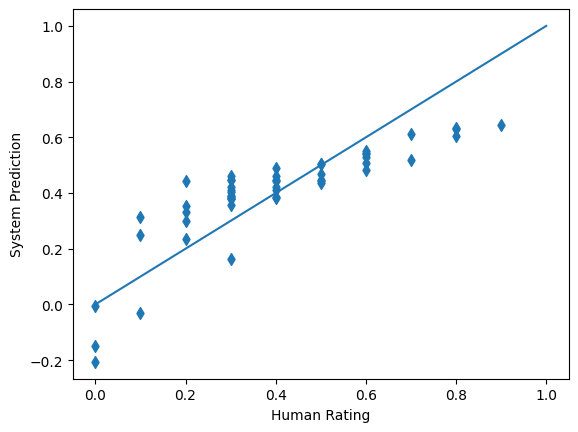

In [119]:
### Drawing Plot for Linear Regression
import matplotlib.pyplot as plt

### Human-rating & SVR prediction의 산점도 그리기
# plt.scatter(humanRating, svm_reg.predict(allBPD), marker = 'd')
plt.scatter(humanRating, lr.predict(simpleAddition), marker = 'd')

plt.plot(x,y,'-')

### 산점도 라벨링
plt.xlabel('Human Rating')
plt.ylabel('System Prediction')
plt.show()

In [55]:
### Simple Addtion Pearson R

from scipy.stats import pearsonr

tempHumanRating = np.squeeze(np.asarray(humanRating))
tempPrediction = np.squeeze(np.asarray(lr.predict(simpleAddition).reshape(-1,1)))

pearsonr(tempHumanRating,tempPrediction )

PearsonRResult(statistic=0.8358046844215196, pvalue=4.303015036215309e-14)

# Ridge Regression

In [99]:
# Ridge Regression
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.001)
ridge.fit(train_input, train_target)

Ridge(alpha=0.001)

In [100]:
print(ridge.score(train_input, train_target))    # 훈련세트 점수
print(ridge.score(test_input, test_target))    # 테스트세트 점수

0.7020214007490548
0.6874434007574135


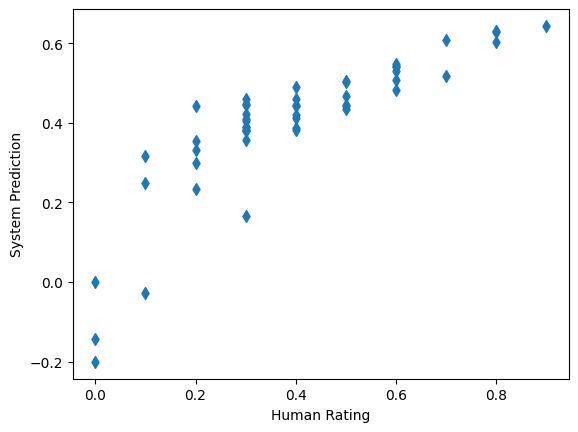

In [101]:
### Drawing Plot for Ridge Regression
import matplotlib.pyplot as plt

### Human-rating & SVR prediction의 산점도 그리기
# plt.scatter(humanRating, svm_reg.predict(allBPD), marker = 'd')
plt.scatter(humanRating, ridge.predict(simpleAddition), marker = 'd')



### 산점도 라벨링
plt.xlabel('Human Rating')
plt.ylabel('System Prediction')
plt.show()

# Lasso Regression

In [108]:
# 라쏘 회귀
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, max_iter = 10000)
lasso.fit(train_input, train_target)

Lasso(alpha=0.01, max_iter=10000)

In [109]:
print(lasso.score(train_input, train_target))    # 훈련세트 점수
print(lasso.score(test_input, test_target))    # 테스트세트 점수

0.0
-0.006457561567358772
